# Image tiling

To parallelize SourceXtractor++ on different machines, one option is to slice the images in smaller tiles. This notebook allows to create such tiles, with overlaps and customizable size.

In [1]:
import os
from typing import Union
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales, pixel_to_skycoord
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
from astropy.visualization.wcsaxes import add_scalebar
import astropy.units as u

In [2]:
def add_good_scalebar(ax, wcs, color='white', fraction=0.25, corner='bottom right', pad=0.1):
    """
    Utility function for astropy.visualization.wcsaxes.add_scalebar
    to automaticaly resize the scalebar to the size of the image.

    ax : matplotlib.pyplot.Axes where to draw the scale bar
    wcs : WCS of the image
    color : color of the scale bar
    fraction : fraction of the image to aim for the scale bar (will always be smaller)
    corner : where to place the scale bar
    pad : padding around the scale bar
    """
    width = abs(proj_plane_pixel_scales(wcs)[0]*wcs.pixel_shape[0])*u.degree
    good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
    dist = np.array([(fraction*width-val).value for val in good_values])
    dist[dist<0] = np.inf
    size = good_values[np.argmin(dist)]
    add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size='x-large'), label_top=True, pad=pad, corner=corner)

In [3]:
def create_tiles(data, wcs, centers, sizes):
    """
    Create the tiles out of a big image and given center position and sizes of tiles

    data : data of the main image
    wcs : WCS of the main image
    centers : list of SkyCoord for the center of each tile
    sizes : list of tuple of angular sizes for each tile

    Returns : list of Cutout2D representing the tiles
    """
    tiles = []
    for i in range(len(centers)):
        cutout = Cutout2D(data, position=centers[i], size=sizes[i], wcs=wcs, mode='partial', fill_value=0.0)
        tiles.append(cutout)
    return tiles

def tile_positions(wcs, nx, ny, overlap):
    """
    Calculates the centers and sizes of tiles based on a grid

    wcs : WCS of the main image
    nx/y : number of tiles on the x/y axis
    overlap : angular size of the overlap between tiles

    Returns : lists of centers and sizes for the tiles
    """
    width, height = wcs.pixel_shape
    pixscale = abs(proj_plane_pixel_scales(wcs)[0])*u.degree
    overlap_px = int(overlap/pixscale)
    width_tile = (width-overlap_px)/nx + overlap_px
    height_tile = (height-overlap_px)/ny + overlap_px
    centers = []
    sizes = []
    for j in range(ny):
        for i in range(nx):
            center = pixel_to_skycoord(0.5*width_tile + i*(width_tile-overlap_px), 0.5*height_tile + j*(height_tile-overlap_px), wcs)
            centers.append(center)
            sizes.append((width_tile*pixscale, height_tile*pixscale))
    return centers, sizes

def tile_grid(wcs, max_size_x, max_size_y, overlap):
    """
    Calculates the grid size for a given maximum angular tile size

    wcs : WCS of the main image
    max_size_x/y : maximum angular size on the x/y axis for the tiles (without overlap)
    overlap : angular size of the overlap between tiles

    Returns : number of tiles on the x and y axis
    """
    width_px, height_px = wcs.pixel_shape
    pixscale = abs(proj_plane_pixel_scales(wcs)[0])*u.degree
    width, height = width_px*pixscale, height_px*pixscale
    nx, ny = int(width/max_size_x)+1, int(height/max_size_y)+1
    return nx, ny

def save_tiles(tiles, main_filename, save_folder=None, verbose=False):
    """
    Saves the tiles as FITS images

    tiles : list of Cutout2D representing the tiles
    main_filename : filename of the main image
    save_folder : folder to save the cutouts in.
        By default, tiles are saved in a `cutout` sub-folder where the main image is.
    """
    hdu = fits.open(main_filename, memmap=True)[0]
    for i, tile in enumerate(tiles):
        if verbose: print(f"Tile {i+1} / {len(tiles)}")
        hdu.data = tile.data
        hdu.header.update(tile.wcs.to_header())
        parsed_name = main_filename.split("/")
        folder = "/".join(parsed_name[:-1])
        init_name = parsed_name[-1]
        name = f"{'.'.join(init_name.split('.')[:-1])}_tile-{i}.fits"
        if save_folder is None: save_folder = f"{folder}/tiles"
        if not os.path.exists(save_folder): os.mkdir(save_folder) 
        hdu.writeto(f"{save_folder}/{name}", overwrite=True)

def plot_tiles(nx, ny, tiles, plot_main=False, data=None, wcs=None):
    """
    Plot the tiles for visual inspection

    nx/y : number of tiles on the x/y axis
    tiles : list of Cutout2D representing the tiles
    plot_main : whether to plot the main image or not
    data : data array of the main image (required if plot_main==True)
    wcs : WCS of the main image (required if plot_main==True)
    """
    if plot_main:
        fig = plt.figure(layout='constrained', figsize=(12,6))
        gs = GridSpec(ny, nx*2, figure=fig)
        ax_main = fig.add_subplot(gs[:,nx:], projection=wcs)
        norm = ImageNormalize(data, interval=ZScaleInterval())
        ax_main.imshow(data, cmap='gray', origin='lower', norm=norm)
        add_good_scalebar(ax_main, wcs)
        ax_main.set_xlabel('Right Ascension (J2000)')
        ax_main.set_ylabel('Declination (J2000)')
    else:
        fig = plt.figure(layout='constrained', figsize=(6,6))
        gs = GridSpec(ny, nx, figure=fig)
        norm = ImageNormalize(tiles[0].data, interval=ZScaleInterval())
    for j in range(ny):
        for i in range(nx):
            tile = tiles[i+ny*j]
            ax = fig.add_subplot(gs[ny-j-1,i], projection=tile.wcs)
            ax.imshow(tile.data, cmap='gray', origin='lower', norm=norm)
            ax.set_axis_off()

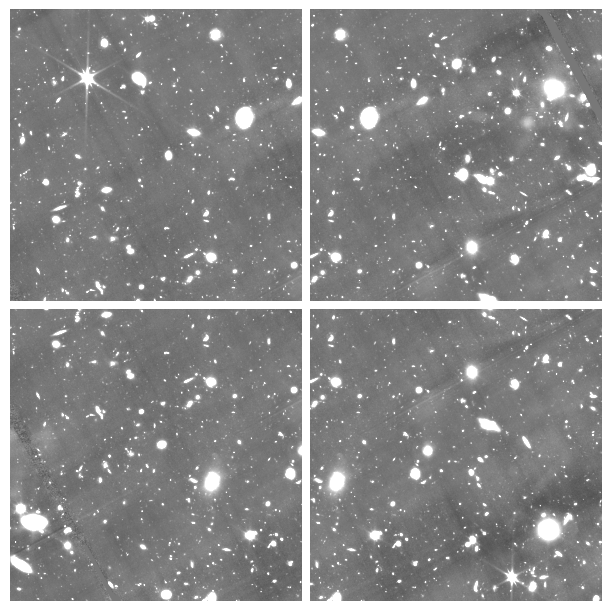

In [30]:
# filename = f"/FlashStorage/image/GDS/gds-grizli-v7.2-f200w-clear_drc_sci.fits"
filename = f"/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f200w-clear_drc_sci_cutout.fits"

hdu = fits.open(filename, memmap=True)[0]
wcs = WCS(hdu.header)
data = hdu.data

max_size = 1.0*u.arcmin
overlap = 0.5*u.arcmin
nx, ny = tile_grid(wcs, max_size, max_size, overlap)
centers, sizes = tile_positions(wcs, nx, ny, overlap)
tiles = create_tiles(data, wcs, centers, sizes)

plot_tiles(nx, ny, tiles, plot_main=False)
plt.show()

## Batch tiling

The following part is about creating and saving tiles for multi-band images.

In [6]:
def batch_tiling(generic_filename   : str,
                 tile_max_size      : u.Quantity,
                 overlap            : u.Quantity,
                 save_folder        : str = None, 
                 plot               : bool = False,
                 verbose            : bool = False) -> None :
    """
    Create tiles for all selected images, 
    centered on the same points and with the same angular size.

    * `generic_filename` (`str` with wildcard) : 
        Generic filename for the images to process.
        Can use wildcards (*,?) readable by `glob.glob`.
    * `tile_max_size` (`u.Quantity`) :
        Maximum angular size of the tiles (without overlap)
    * `overlap` (`u.Quantity`) :
        Angular size of overlap between tiles
    * `save_folder` (`str`, optional):
        Folder to save the cutouts in.
        By default, the images will be saved in a `cutout` sub-folder of the initial folder.
    * `plot` (`bool`, optional):
        Plots the tiles for the first band with MinMax and Log stretching.
    * `verbose` (`bool`, optional)
    """
    image_list = glob.glob(generic_filename)
    n = len(image_list)
    if verbose: print(f"Number of images found : {n}")
    if verbose: print(f"Images found :")
    if verbose: 
        for img in image_list: print(img)
    for i,img in enumerate(image_list):
        print(f"Image {i+1} / {n}")
        # Load image
        hdu = fits.open(img, memmap=True)[0]
        wcs = WCS(hdu.header)
        data = hdu.data
        # Calculate tiling on first image
        if i==0:
            nx, ny = tile_grid(wcs, tile_max_size, tile_max_size, overlap)
            centers, sizes = tile_positions(wcs, nx, ny, overlap)
        # Tiles the image
        tiles = create_tiles(data, wcs, centers, sizes)
        # Save tiles
        save_tiles(tiles, img, save_folder, verbose=verbose)
        if plot & (i==0):
            plot_tiles(nx, ny, tiles, plot_main=False)
    plt.show()

Number of images found : 34
Images found :
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f090w-clear_drc_sci_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f090w-clear_drc_wht_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f115w-clear_drc_sci_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f115w-clear_drc_wht_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f150w-clear_drc_sci_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f150w-clear_drc_wht_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f182m-clear_drc_sci_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f182m-clear_drc_wht_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f200w-clear_drc_sci_cutout.fits
/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/gds-grizli-v7.2-f200w-clear_drc_wht_cutout.fits
/home/ec2-user/DA

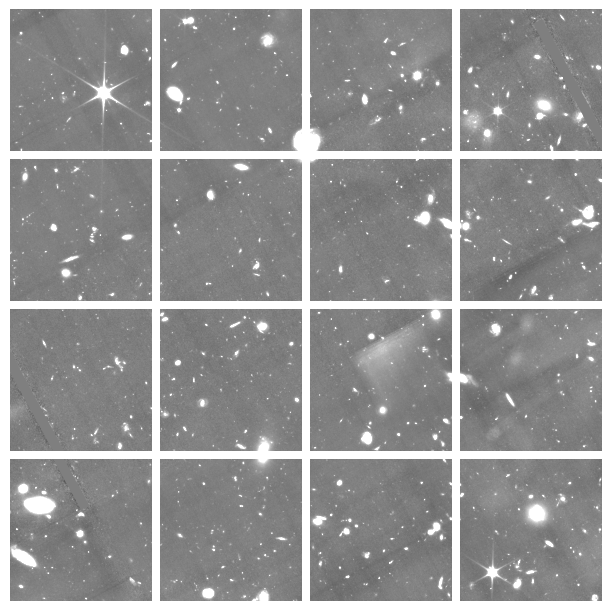

In [9]:
batch_tiling(generic_filename="/home/ec2-user/DAWN/DJA-SEpp/image/GDS/cutout/*.fits",
             tile_max_size=0.5*u.arcmin, overlap=0.0*u.arcmin,
             plot=True, verbose=True)
# batch_tiling(generic_filename="/FlashStorage/image/GDS/*.fits",
#              tile_max_size=2.0*u.arcmin, overlap=0.5*u.arcmin,
#              plot=True, verbose=True)